# Intitialization

In [1]:
%reset -f
import importlib
import numpy as np
import os

import matplotlib
import matplotlib.pyplot as plt


au_to_ev = 27.211324570273 # convert atomic units to electron volts (for frequencies)
au_to_Vm = 5.142206747E+11 # convert atomic units to V/m (for field)
au_to_D = (8.4783536255 / 3.335640952) # convert atomic units to Debye (for dipole)
au_to_fs = 0.02418884254 # convert atomic units to femtosecond (for time)

L_xyz = ['x', 'y', 'z'] # used for plots 

In [2]:
import cp2kRTPtools
print(importlib.reload(cp2kRTPtools))

from cp2kRTPtools import open_output_files
from cp2kRTPtools import ft_utils
from cp2kRTPtools import mo_proj

<module 'cp2kRTPtools' from '/users/glebreton/.local/lib/python3.6/site-packages/cp2kRTPtools/__init__.py'>


# Tools to open cp2k output files

## Total Energy

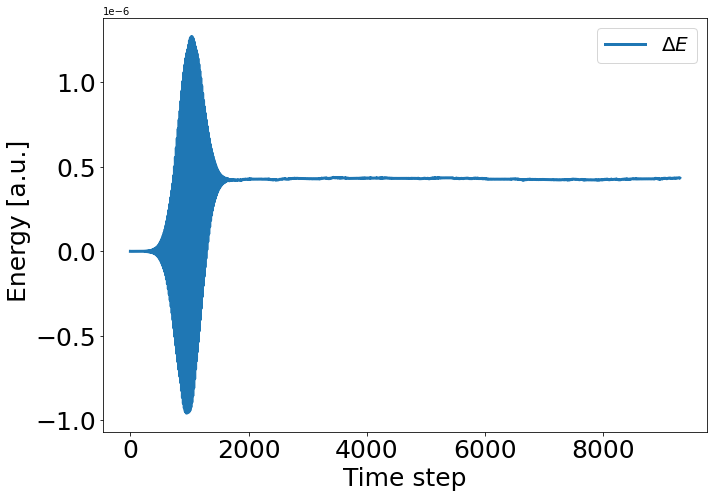

In [3]:
filename = 'RTP_vg_field.out'

L_energy = open_output_files.read_energy(filename)

plt.figure(1, figsize=(10, 7))
plt.plot(L_energy-L_energy[0], lw=3, label=r'$\Delta E$')
plt.xlabel(r'Time step' , fontsize=25)
#plt.xlim([800, 900])
plt.ylabel(r' Energy [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

## FORCE_EVAL%DFT%PRINT%MOMENTS

### Dipole

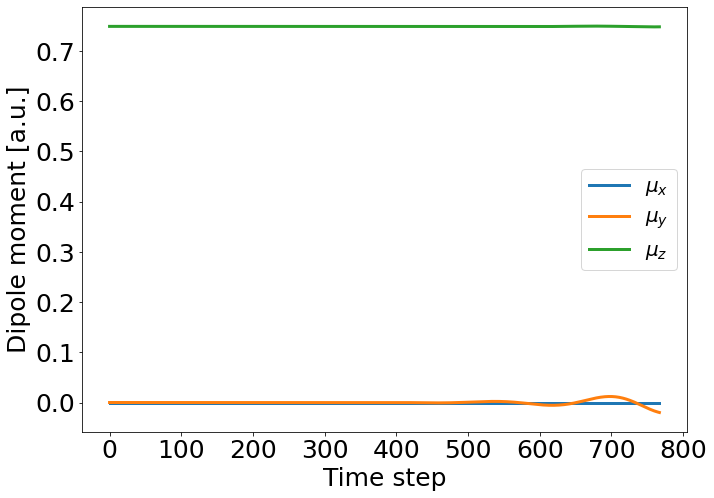

In [4]:
filename = 'lg_moments'

# Be aware that cp2k returns by default the dipole moment in Debye and not in atomic units
L_lg_dipole = open_output_files.read_dipole_moment(filename)/au_to_D 

plt.figure(1, figsize=(10, 7))
for k in range(0, 3, 1):
    plt.plot(L_lg_dipole[:, k], lw=3, label=r'$\mu_{' + L_xyz[k] + '}$')
plt.xlabel(r'Time step' , fontsize=25)
plt.ylabel(r'Dipole moment [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

### Momentum

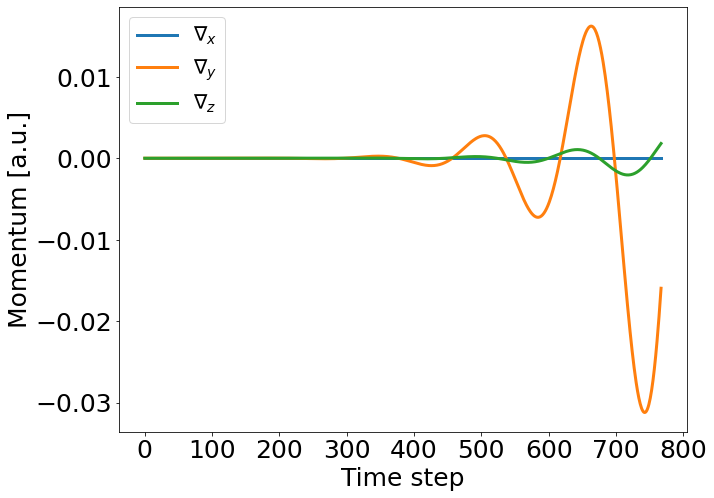

In [5]:
filename = 'lg_moments'

L_lg_momentum = open_output_files.read_momentum(filename)
plt.figure(1, figsize=(10, 7))
for k in range(0, 3, 1):
    plt.plot(L_lg_momentum[:, k], lw=3, label=r'$\nabla_{' + L_xyz[k] + '}$')
plt.xlabel(r'Time step' , fontsize=25)
plt.ylabel(r'Momentum [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)


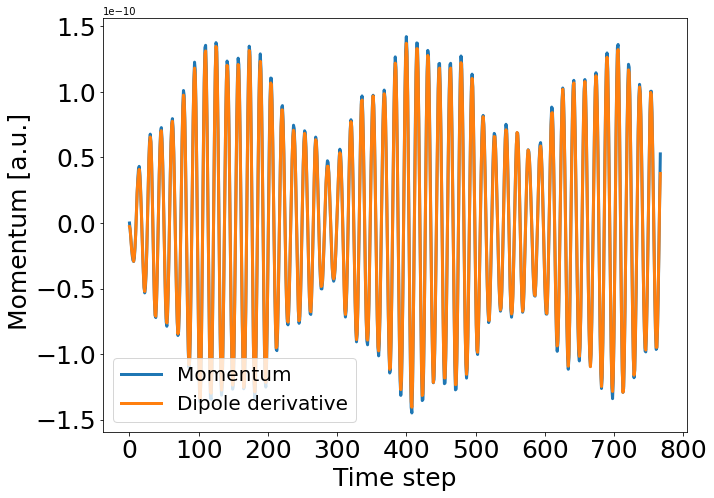

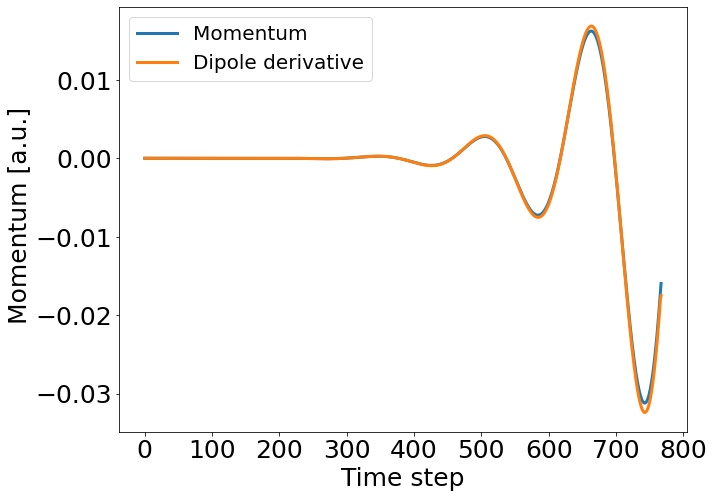

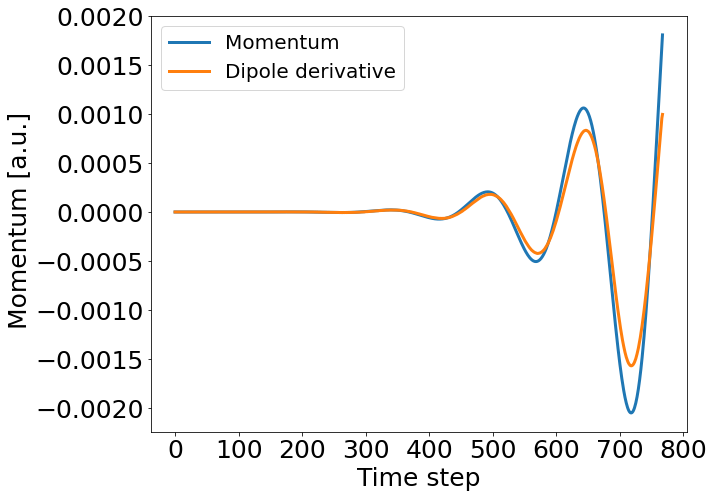

In [6]:
#In the length gauge, we have momenta = d dipole / dt 
t_end = len(L_lg_momentum)
time_step_au = 0.0005/au_to_fs
L_time = np.array([k*time_step_au for k in range(t_end)])


for i in range(0, 3, 1):
    plt.figure(i, figsize=(10, 7))
    plt.plot(L_lg_momentum[:, i], label='Momentum',  lw=3)
    plt.plot(np.gradient(L_lg_dipole[:, i], time_step_au), '-', lw=3, label='Dipole derivative')

    plt.xlabel(r'Time step' , fontsize=25)
    plt.ylabel(r' Momentum [a.u.]', fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.legend(fontsize=20)
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)


### Non-local pseudo potential commutators and evaluation

Time step, 3: (51, 3)


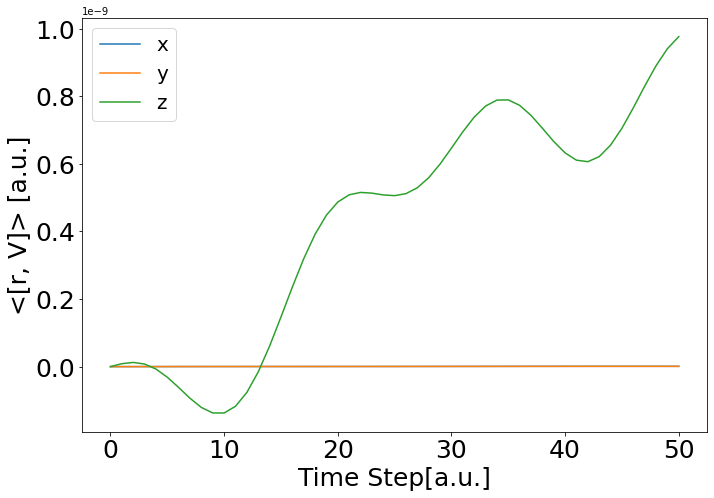

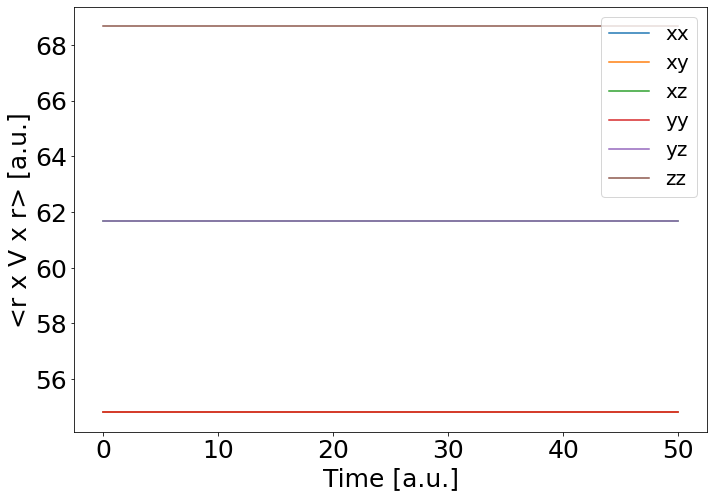

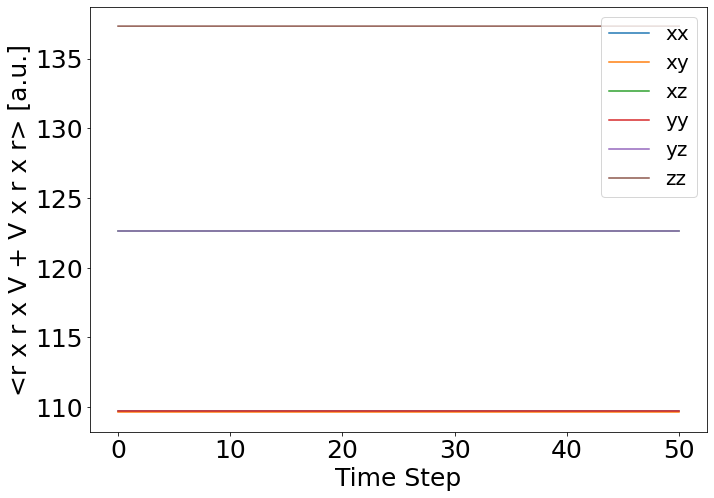

In [7]:
filename = 'co_vg_pseudo_moments'

L_com_r_v_vg, L_rvr_vg, L_rrv_vrr_vg = open_output_files.read_NL_terms(filename)

print('Time step, 3:', L_com_r_v_vg.shape)

L_quadru_xyz = ['xx', 'xy', 'xz', 'yy', 'yz', 'zz']

plt.figure(1, figsize=(10, 7))
for i in range(0, 3, 1):
    plt.plot(L_com_r_v_vg[:, i], label=L_xyz[i])
plt.xlabel(r'Time Step[a.u.]' , fontsize=25)
plt.ylabel(r'<[r, V]> [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

plt.figure(2, figsize=(10, 7))
for i in range(0, 6, 1):
    plt.plot(L_rvr_vg[:, i], label=L_quadru_xyz[i])
plt.xlabel(r'Time [a.u.]' , fontsize=25)
plt.ylabel(r'<r x V x r> [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

plt.figure(3, figsize=(10, 7))
for i in range(0, 6, 1):
    plt.plot(L_rrv_vrr_vg[:, i], label=L_quadru_xyz[i])
plt.xlabel(r'Time Step' , fontsize=25)
plt.ylabel(r'<r x r x V + V x r x r> [a.u.]', fontsize=25)
#plt.xlim([15, 18])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

In [8]:
def compute_product_quadru(L_quadru, L_in):
    '''
    Compute the product of a symmetric 3x3 matrix with a vector when the matrix is encoded as: XX, XY, XZ, YY, YZ, ZZ
    '''
    L_out = np.zeros((len(L_in[:,0]), 3))
    L_out[:,0] = L_quadru[:,0]*L_in[:,0] + L_quadru[:,1]*L_in[:,1] + L_quadru[:,2]*L_in[:,2]
    L_out[:,1] = L_quadru[:,1]*L_in[:,0] + L_quadru[:,3]*L_in[:,1] + L_quadru[:,4]*L_in[:,2]
    L_out[:,2] = L_quadru[:,2]*L_in[:,0] + L_quadru[:,4]*L_in[:,1] + L_quadru[:,5]*L_in[:,2]
    return(L_out)

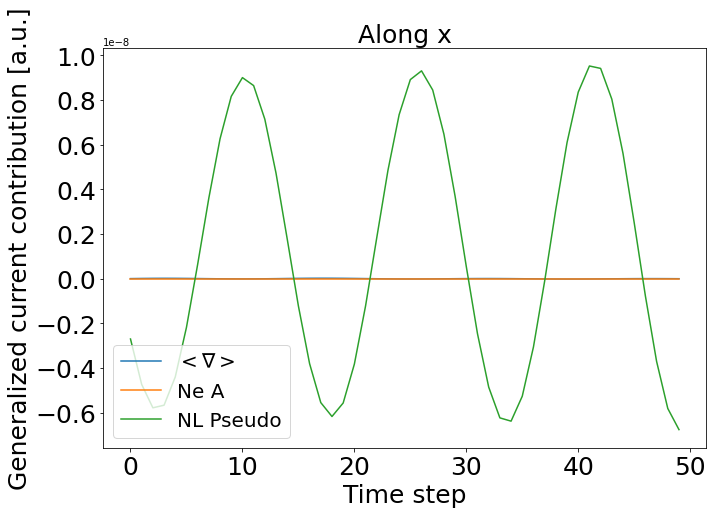

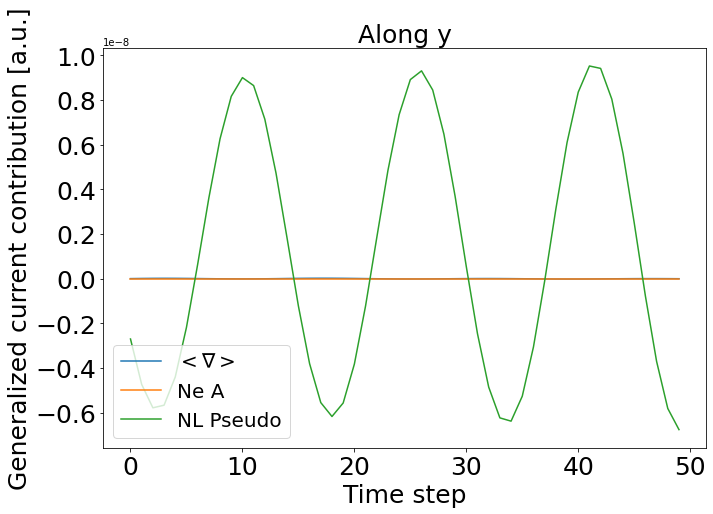

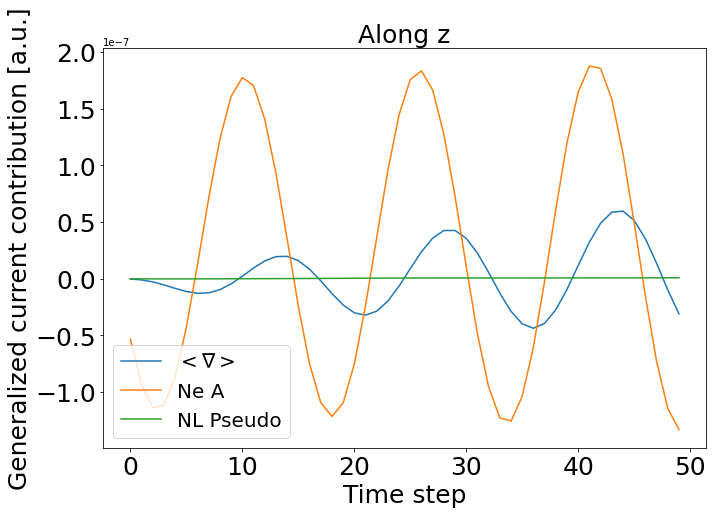

In [9]:
filename = 'co_vg_pseudo_moments'
L_momentum = open_output_files.read_momentum(filename)[0:] 
L_com_r_v, L_rvr, L_rrv_vrr = open_output_files.read_NL_terms(filename)

# we remove the first time-step value which is in fact the ground state one
L_momentum = np.array(L_momentum[1:, :])
L_com_r_v = np.array(L_com_r_v[1:, :])
L_rvr = np.array(L_rvr[1:, :])
L_rrv_vrr = np.array(L_rrv_vrr[1:, :])

filename = 'co_vg_pseudo_applied_field'
L_vector_potential = open_output_files.read_applied_field(filename)

# Correction from vector potential
Ne = 14 # for carbon-monoxide molecule
L_corr_vp = Ne*L_vector_potential

# Correction Non-Local Pseudo Potential:
L_corr_rvr = 2*compute_product_quadru(L_rvr, L_vector_potential)
L_corr_rrv_vrr = -1*compute_product_quadru(L_rrv_vrr, L_vector_potential)

L_corr_nl = L_com_r_v + L_corr_rvr + L_corr_rrv_vrr

for i in range(0, 3, 1):
    plt.figure(i, figsize=(10, 7))
    plt.plot(L_momentum[:, i], label=r'$<\nabla>$')
    plt.plot(L_corr_vp[:, i], label=r'Ne A')
    plt.plot(L_corr_nl[:, i], label='NL Pseudo')
    plt.title('Along ' + L_xyz[i], fontsize=25)
    plt.xlabel(r'Time step' , fontsize=25)
    plt.ylabel(r'Generalized current contribution [a.u.]', fontsize=25)
    #plt.xlim([15, 18])
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.legend(fontsize=20)
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

## FORCE_EVAL%DFT%PRINT%AO_MATRICES 

### Overlap matrix

In [10]:
filename = 'overlap_matrix_small'
startkey = 'OVERLAP MATRIX'

L_ao_matrix = open_output_files.read_ao_matrix(filename, startkey)
print('Nbr AO, Nbr AO:', L_ao_matrix.shape)

# Check that the matrix is not null
print('Should be none zero:', np.sum(np.sum(L_ao_matrix**2))) 
# In the case of overlap matrix, the matrix is symmetric    
print('Should be zero for overlap matrix (or other symmetric matrices):', np.sum(np.sum(L_ao_matrix-L_ao_matrix.T)**2)) 


Nbr AO, Nbr AO: (3, 3)
Should be none zero: 5.932927036774
Should be zero for overlap matrix (or other symmetric matrices): 0.0


In [11]:
filename = 'overlap_matrix'
startkey = 'OVERLAP MATRIX'

L_ao_matrix = open_output_files.read_ao_matrix(filename, startkey)
print('Nbr AO, Nbr AO:', L_ao_matrix.shape)

# Check that the matrix is not null
print('Should be none zero:', np.sum(np.sum(L_ao_matrix**2))) 
# In the case of overlap matrix, the matrix is symmetric    
print('Should be zero for overlap matrix:', np.sum(np.sum(L_ao_matrix-L_ao_matrix.T)**2)) 


Nbr AO, Nbr AO: (70, 70)
Should be none zero: 169.57568769174998
Should be zero for overlap matrix: 0.0


##  FORCE_EVAL%DFT%PRINT%MO

### Output of the usual SCF cycle (ground state)

In [12]:
filename = 'co_omega_520_F10_y_mo_coeff'

L_ref_mo = open_output_files.read_ref_mo(filename)   

#How to call the different elements: [Spin, Mo, Ao]
print('(nbr spin, Nbr MO, nbr AO)=', L_ref_mo.shape)


(nbr spin, Nbr MO, nbr AO)= (2, 11, 70)


### Time-dependent MO coeff 

In [13]:
filename = 'co_omega_520_F10_y_mo_coeff'

L_td_MO_alpha, L_td_MO_beta = open_output_files.read_td_mo(filename) 

#How to call the different elements: [Time, Mo, Ao]
print('Alpha spin, (nbr time step, Nbr MO, nbr AO)=', L_td_MO_alpha.shape)
print('Beta spin, (nbr time step, Nbr MO, nbr AO)=', L_td_MO_beta.shape)



Read time step:  1
Read time step:  2
Read time step:  3
Read time step:  4
Read time step:  5
Read time step:  6
Read time step:  7
Read time step:  8
Read time step:  9
Read time step:  10
Read time step:  11
Read time step:  12
Read time step:  13
Read time step:  14
Read time step:  15
Read time step:  16
Read time step:  17
Read time step:  18
Read time step:  19
Read time step:  20
Read time step:  21
Read time step:  22
Read time step:  23
Read time step:  24
Read time step:  25
Read time step:  26
Read time step:  27
Read time step:  28
Read time step:  29
Read time step:  30
Read time step:  31
Read time step:  32
Read time step:  33
Read time step:  34
Read time step:  35
Read time step:  36
Read time step:  37
Read time step:  38
Read time step:  39
Read time step:  40
Read time step:  41
Read time step:  42
Read time step:  43
Read time step:  44
Read time step:  45
Read time step:  46
Read time step:  47
Read time step:  48
Read time step:  49
Read time step:  50
Read time

Read time step:  398
Read time step:  399
Read time step:  400
Read time step:  401
Read time step:  402
Read time step:  403
Read time step:  404
Read time step:  405
Read time step:  406
Read time step:  407
Read time step:  408
Read time step:  409
Read time step:  410
Read time step:  411
Read time step:  412
Read time step:  413
Read time step:  414
Read time step:  415
Read time step:  416
Read time step:  417
Read time step:  418
Read time step:  419
Read time step:  420
Read time step:  421
Read time step:  422
Read time step:  423
Read time step:  424
Read time step:  425
Read time step:  426
Read time step:  427
Read time step:  428
Read time step:  429
Read time step:  430
Read time step:  431
Read time step:  432
Read time step:  433
Read time step:  434
Read time step:  435
Read time step:  436
Read time step:  437
Read time step:  438
Read time step:  439
Read time step:  440
Read time step:  441
Read time step:  442
Read time step:  443
Read time step:  444
Read time ste

Read time step:  796
Read time step:  797
Read time step:  798
Read time step:  799
Read time step:  800
Read time step:  801
Read time step:  802
Read time step:  803
Read time step:  804
Read time step:  805
Read time step:  806
Read time step:  807
Read time step:  808
Read time step:  809
Read time step:  810
Read time step:  811
Read time step:  812
Read time step:  813
Read time step:  814
Read time step:  815
Read time step:  816
Read time step:  817
Read time step:  818
Read time step:  819
Read time step:  820
Read time step:  821
Read time step:  822
Read time step:  823
Read time step:  824
Read time step:  825
Read time step:  826
Read time step:  827
Read time step:  828
Read time step:  829
Read time step:  830
Read time step:  831
Read time step:  832
Read time step:  833
Read time step:  834
Read time step:  835
Read time step:  836
Read time step:  837
Read time step:  838
Read time step:  839
Read time step:  840
Read time step:  841
Read time step:  842
Read time ste

## FORCE_EVAL%DFT%REAL_TIME_PROPAGATION%PRINT%FIELD

### Length gauge case: electric field

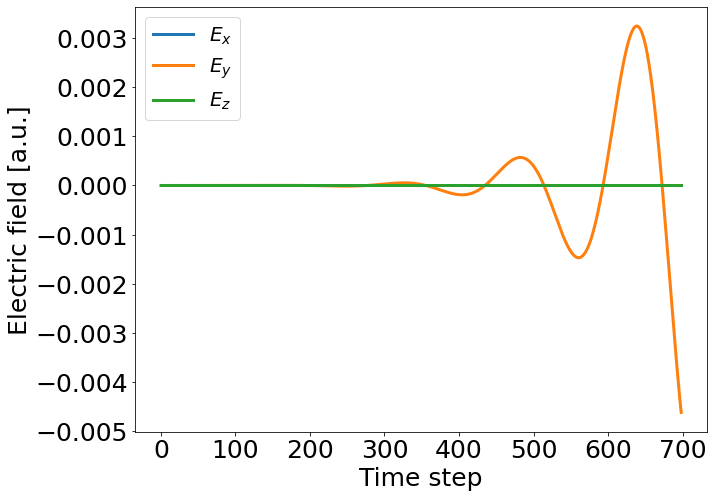

In [14]:
filename = 'lg_applied_field'

L_lg_field = open_output_files.read_applied_field(filename)
plt.figure(1, figsize=(10, 7))
for k in range(0, 3, 1):
    plt.plot(L_lg_field[:, k], lw=3, label=r'$E_{' + L_xyz[k] + '}$')
plt.xlabel(r'Time step' , fontsize=25)
plt.ylabel(r'Electric field [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

### Velocity gauge case: vector potential

In [15]:
filename = 'vg_applied_field'

L_vg_field = open_output_files.read_applied_field(filename)
plt.figure(1, figsize=(10, 7))
for k in range(0, 3, 1):
    plt.plot(L_vg_field[:, k], lw=3, label=r'$E_{' + L_xyz[k] + '}$')
plt.xlabel(r'Time step' , fontsize=25))
plt.ylabel(r'Vector Potential [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

SyntaxError: invalid syntax (<ipython-input-15-ec6d0f25e8b7>, line 7)

### Length and Velocity gauge

In [ ]:
t_end = 700
time_step_au = 0.0005/au_to_fs
L_time = np.array([k*time_step_au for k in range(t_end)])


for i in range(0, 3, 1):
    plt.figure(i, figsize=(10, 7))
    plt.plot(L_lg_field[:, i], 's', label='LG')
    plt.plot(L_vg_field[:, i], label='VG',  lw=3)
    plt.plot(-np.gradient(L_vg_field[:, i], time_step_au), '-', lw=3, label='-VG derivative')

    plt.xlabel(r'Time Step' , fontsize=25)
    plt.ylabel(r' Fields along ' + L_xyz[i] + ' [a.u.]', fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.legend(fontsize=20)
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

## FORCE_EVAL%DFT%REAL_TIME_PROPAGATION%PRINT%PROJECTION_MO

In [ ]:
# See also the tutorial related to Real Time TDDFT with explicit field (XRay) on Carbone Monoxide in cp2k.org
# In this case, the population and the phase is available:
filename = 'H2O_projection_1-PROJ_MO-1-REF-4.dat'
L_popu, L_phase = open_output_files.read_mo_projection(filename)
print('Number of time step:', len(L_popu))
print('Number of TD mos:', len(L_popu[0,:]))

# IN this case, only the total population (summed over the reference states) is available:
filename ='H2O_projection_1-PROJ_MO-6-ALL_REF.dat'
L_popu = open_output_files.read_mo_projection(filename)
print('Number of time step:', len(L_popu))
print('Number of TD mos:', len(L_popu[0,:]))


In [ ]:
# In these cases, all TD MOs population are summed. So that there is only one population per time step 
filename = 'H2O_projection_1-PROJ_MO-7-ALL_REF.dat'    
L_popu = open_output_files.read_mo_projection(filename)
print('Number of time step:', len(L_popu))


# Projection of the TD−MO coefficients

Project the time dependent molecular orbital (MO) coefficients to a reference state. 
The reference state can be defined using either time-dependent MO or from a static SCF calculation. 
For instance the HOMO or LUMO of your Ground State calcualtion.


To perform the projection after the CP2K run in python, you should print the Time-Dependent MO coefficients of the states you want to project (FORCE_EVAL%DFT%PRINT%MO) and the overlap matrix (FORCE_EVAL%DFT%PRINT%AO_MATRICES). 

Note that this procedure is also available in CP2K using the print: FORCE_EVAL%DFT%REAL_TIME_PROPAGATION%PRINT%PROJECTION_MO. In this case, you do not need to print the TD-MOs nor the overlap matrix. 

## Phase evolution of steady state

In [ ]:
filename = 'co_omega_520_F10_y_mo_coeff'

L_ref_mo = open_output_files.read_ref_mo(filename) 
L_td_MO_alpha, L_td_MO_beta = open_output_files.read_td_mo(filename) 

ts_nbr, mo_nbr, ao_nbr = L_td_MO_alpha.shape
print(ts_nbr, mo_nbr, ao_nbr)

In [ ]:
# use an occupied MO, ie < 8 for carbone monoxide
# Note that the more inner MO you analyze, the more associated energetic level, the higher the associated frequency
# Thus, small mo_index lead to high speed phase evolution, large mo_index to slower evolution. 
mo_index = 1
L_mo_of_interest = np.array(L_td_MO_alpha[:, mo_index, :])

L_mean_phase = np.zeros(ts_nbr)
for t in range(ts_nbr):
    L_angle = np.angle(L_mo_of_interest[t])
    L_amplitude = np.absolute(L_mo_of_interest[t])
    L_mean_phase[t] = np.sum(L_angle*L_amplitude)/np.sum(L_amplitude)
    
plt.figure(1, figsize=(10, 7))
plt.plot(L_mean_phase*180/np.pi, 'o-')
plt.xlabel(r'Time Step' , fontsize=25)
plt.ylabel(r'Average phase of the MO [deg]', fontsize=25)
plt.xlim([0, 100])
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 


## Approximate projection

In [ ]:
# TD state with a GS reference 
# We project the Time-Dependent state on the reference one: the projection amplitude should be 1 and the phase proportional to the energy of the state
mo_index = 5
L_mo_of_interest = np.array(L_td_MO_alpha[:, mo_index, :])
L_ref_MO = np.array(L_ref_mo[0, mo_index])

L_projection, L_phase = mo_proj.compute_projection_ref_td(L_ref_MO, L_mo_of_interest)

print('Value of the projection at t=1', L_projection[0])

plt.figure(1, figsize=(10, 7))
plt.plot(L_projection, 'o')
plt.xlabel(r'Time Step' , fontsize=25)
plt.ylabel(r'Projection', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim([0, 1.05])
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 

plt.figure(2, figsize=(10, 7))
plt.plot(L_phase*180/np.pi, '-o')
plt.xlabel(r'Time Step' , fontsize=25)
plt.ylabel(r'Phase of projection', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 

In [ ]:
# TD state with a TD reference 
# We project the Time-Dependent state on the first time step one: the projection amplitude should be 1 and the phase proportional to the energy of the state
mo_index = 5
L_mo_of_interest = np.array(L_td_MO_alpha[:, mo_index, :])
L_ref_MO = np.array(L_td_MO_alpha[0, mo_index, :])

L_projection, L_phase = mo_proj.compute_projection_ref_td(L_ref_MO, L_mo_of_interest)

print('Value of the projection at t=1', L_projection[0])

plt.figure(1, figsize=(10, 7))
plt.plot(L_projection, 'o')
plt.xlabel(r'Time Step' , fontsize=25)
plt.ylabel(r'Projection', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim([0, 1.05])
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 

plt.figure(2, figsize=(10, 7))
plt.plot(L_phase*180/np.pi, '-o')
plt.xlabel(r'Time Step' , fontsize=25)
plt.ylabel(r'Phase of projection', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 

In [ ]:
# TD state with a GS reference 
# We project the Time-Dependent state on a difference reference one: the projection amplitude should be smaller than 1. May not be equal to zero because here we are not using the overlap matrix here
mo_index = 0
mo_ref_index = 2
L_mo_of_interest = np.array(L_td_MO_alpha[:, mo_index, :])
L_ref_MO = np.array(L_ref_mo[0, mo_ref_index])

L_projection, L_phase = mo_proj.compute_projection_ref_td(L_ref_MO, L_mo_of_interest)

print('Value of the projection at t=1', L_projection[0])

plt.figure(1, figsize=(10, 7))
plt.plot(L_projection, 'o')
plt.xlabel(r'Time Step' , fontsize=25)
plt.ylabel(r'Projection', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim([0, 1.05])
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 

plt.figure(2, figsize=(10, 7))
plt.plot(L_phase*180/np.pi, '-o')
plt.xlabel(r'Time Step' , fontsize=25)
plt.ylabel(r'Phase of projection', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 

In [ ]:
# We check how good we are at retreiving the orthonormality of the molecular orbitals
# For the approximate projection, not that good: 
print('Ref MO', 'TD mo', 'Projection amplitude')
for mo_ref_index in range(mo_nbr):
    for mo_index in range(mo_nbr):
        L_mo_of_interest = np.array(L_td_MO_alpha[:2, mo_index, :])
        L_ref_MO = np.array(L_ref_mo[0, mo_ref_index])

        L_projection, L_phase = mo_proj.compute_projection_ref_td(L_ref_MO, L_mo_of_interest)
        print(mo_ref_index, mo_index, L_projection[0])


## Exact projection

In [ ]:
# Load the overlap matrix associated to the RTP calculation of carbone-monoxide
filename = 'overlap_matrix'
startkey = 'OVERLAP MATRIX'

L_ao_matrix = open_output_files.read_ao_matrix(filename, startkey)


In [ ]:
# We check how good we are at retrieving the orthonormality of the molecular orbitals
# For the exact projection, quite good: 
print('Ref MO', 'TD mo', 'Projection amplitude')
for mo_ref_index in range(mo_nbr):
    for mo_index in range(mo_nbr):
        L_mo_of_interest = np.array(L_td_MO_alpha[:2, mo_index, :])
        L_ref_MO = np.array(L_ref_mo[0, mo_ref_index])

        L_projection, L_phase = mo_proj.compute_projection_ref_td(L_ref_MO, L_mo_of_interest, L_ao_matrix=L_ao_matrix)
        print(mo_ref_index, mo_index, L_projection[0])


In [ ]:
# TD state with a GS reference 
# We project the Time-Dependent state on the reference one: the projection amplitude should be 1 and the phase proportional to the energy of the state
mo_index = 5
L_mo_of_interest = np.array(L_td_MO_alpha[:, mo_index, :])
L_ref_MO = np.array(L_ref_mo[0, mo_index])

L_projection, L_phase = mo_proj.compute_projection_ref_td(L_ref_MO, L_mo_of_interest, L_ao_matrix=L_ao_matrix)

print('Value of the projection at t=1', L_projection[0])

plt.figure(1, figsize=(10, 7))
plt.plot(L_projection, 'o')
plt.xlabel(r'Time Step' , fontsize=25)
plt.ylabel(r'Projection', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.ylim([0, 1.05])
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 

plt.figure(2, figsize=(10, 7))
plt.plot(L_phase*180/np.pi, '-o')
plt.xlabel(r'Time Step' , fontsize=25)
plt.ylabel(r'Phase of projection', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 

# Fourier Transform

## 1D 

In [ ]:
# Load the dipole moment from a delta kick RTP calculation of an isolated carbone-monoxide molecule
filename = 'delta_kick_dipole'

# Be aware that cp2k returns by default the dipole moment in Debye and not in atomic units
L_dipole = open_output_files.read_dipole_moment(filename)/au_to_D

# We are interrested in the induced dipole moment: so we have to remove the GS-dipole moment contained in the 
# first element of L_dipole. The time-dependent dipole moment starts at the 2nd element: so we remove the first one (GS).
L_dipole = np.array(L_dipole[1:]-L_dipole[0]) #remove the first point which is the one the GS results
delta_t = 0.0005 #in fs
L_time =  np.array([k*delta_t/au_to_fs for k in range(0, len(L_dipole), 1)])# in a.u.

plt.figure(1, figsize=(10, 7))
for k in range(0, 3, 1):
    plt.plot(L_time, L_dipole[:, k], lw=3, label=r'$\mu_{' + L_xyz[k] + '}$')
plt.xlabel(r'Time [a.u.]' , fontsize=25)
#plt.xlim([800, 900])
plt.ylabel(r'Induced Dipole [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

### Smoothing

In [ ]:
# damping: 
damping_type = 'hann' # 'none' or 'exp' or 'hann'

if damping_type == 'none':
    print('No damping!')
    L_damp = np.zeros(len(L_time)) + 1 
elif damping_type == 'exp':
    tau = 50 #in a.u.
    print('Exponential damping: the tau parameter used is:', tau)
    L_damp = ft_utils.exponential_damping(L_time, tau)
elif damping_type == 'hann':
    print('Hann damping: the t0 and sigma parameters are adjusted automatically.')
    t0 = (L_time[-1]-L_time[0])/2
    sigma = (L_time[-1]-L_time[0])
    L_damp = ft_utils.hann_damping(L_time, t0, sigma)
else:
    raise Exception('ERROR: the damping type is not available. Available ones: "none", "exp" or "hann".')
    
plt.figure(1, figsize=(10, 7))
plt.plot(L_time, L_damp, lw=3)
plt.xlabel(r'Time [a.u.]' , fontsize=25)
plt.ylabel(r'Damping', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  

for k in range(3):
    plt.figure(k+2, figsize=(10, 7))
    plt.plot(L_time, L_dipole[:,k]*L_damp, lw=3, label=r'$\mu_{' + L_xyz[k] + '}$')
    plt.xlabel(r'Time [a.u.]' , fontsize=25)
    plt.ylabel(r'Dipole*Damping [a.u.]', fontsize=25)
    plt.xticks(fontsize=25)
    plt.yticks(fontsize=25)
    plt.legend(fontsize=20)
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    

### Define the frequency domain and perform FT

In [ ]:
# 1  : "Single precision"  
omega_min = 500 # in ev
omega_max = 540 # in ev
N_omega = 100  #nbr of frequencies, note that this nbr may be reduced if the total time of the simulation is too small

omega_precision = 1
L_f = L_dipole[:,1] 
L_omega, L_ft_1 = ft_utils.perform_ft(L_time, L_f, L_damp, omega_min/au_to_ev, omega_max/au_to_ev, N_omega, omega_precision=omega_precision)

# Sanity check for the frequencies: This quantity should be extreamly small because of the T * f = N * 2 * pi condition
print(np.sum(np.sin(L_omega*(L_time[-1]-L_time[0]))**2))

L_omega_1 = L_omega*au_to_ev



In [ ]:
plt.figure(1, figsize=(10, 7))
plt.plot(L_omega_1, L_ft_1.real, lw=3)
plt.xlabel(r'Frequency [ev]' , fontsize=25)
plt.ylabel(r'Re[$\tilde{\mu}$] [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  

plt.figure(2, figsize=(10, 7))
plt.plot(L_omega_1, L_ft_1.imag, lw=3)
plt.xlabel(r'Frequency [ev]' , fontsize=25)
plt.ylabel(r'Im[$\tilde{\mu}$] [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  

plt.figure(3, figsize=(10, 7))
plt.plot(L_omega_1, L_ft_1.real, lw=3, label='Real')
plt.plot(L_omega_1, L_ft_1.imag, lw=3, label='Imag')
plt.xlabel(r'Frequency [ev]' , fontsize=25)
plt.ylabel(r'$\tilde{\mu}$ [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 

plt.figure(4, figsize=(10, 7))
plt.plot(L_omega_1, np.absolute(L_ft_1), lw=3)
plt.xlabel(r'Frequency [ev]' , fontsize=25)
plt.ylabel(r'|$\tilde{\mu}$| [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  

 

In [ ]:
# 2  : "Double precision"  
omega_min = 500 # in ev
omega_max = 540 # in ev
N_omega = 100  #nbr of frequencies, note that this nbr may be reduced if the total time of the simulation is too small

omega_precision = 2
L_f = L_dipole[:,1] 
L_omega, L_ft_2 = ft_utils.perform_ft(L_time, L_f, L_damp, omega_min/au_to_ev, omega_max/au_to_ev, N_omega, omega_precision=omega_precision)

# The sanity check is more complicated to do directly because the function has reduced the nbr of time step to fullfies the T * f = N * 2 * pi rule. 

L_omega_2 = L_omega*au_to_ev

In [ ]:
plt.figure(1, figsize=(10, 7))
plt.plot(L_omega_2, L_ft_2.real, lw=3)
plt.xlabel(r'Frequency [ev]' , fontsize=25)
plt.ylabel(r'Re[$\tilde{\mu}$] [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  

plt.figure(2, figsize=(10, 7))
plt.plot(L_omega_2, L_ft_2.imag, lw=3)
plt.xlabel(r'Frequency [ev]' , fontsize=25)
plt.ylabel(r'Im[$\tilde{\mu}$] [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  

plt.figure(3, figsize=(10, 7))
plt.plot(L_omega_2, L_ft_2.real, lw=3, label='Real')
plt.plot(L_omega_2, L_ft_2.imag, lw=3, label='Imag')
plt.xlabel(r'Frequency [ev]' , fontsize=25)
plt.ylabel(r'$\tilde{\mu}$ [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 

plt.figure(4, figsize=(10, 7))
plt.plot(L_omega_2, np.absolute(L_ft_2), lw=3)
plt.xlabel(r'Frequency [ev]' , fontsize=25)
plt.ylabel(r'|$\tilde{\mu}$| [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  

 

In [ ]:
# -1  : "Highest precision" 
omega_min = 500 # in ev
omega_max = 540 # in ev
N_omega = 100  #nbr of frequencies, note that this nbr may be reduced if the total time of the simulation is too small

omega_precision = -1
L_f = L_dipole[:,1] 
L_omega, L_ft_h = ft_utils.perform_ft(L_time, L_f, L_damp, omega_min/au_to_ev, omega_max/au_to_ev, N_omega, omega_precision=omega_precision)

# The sanity check is more complicated to do directly because the function has reduced the nbr of time step to fullfies the T * f = N * 2 * pi rule. 

L_omega_h = L_omega*au_to_ev


In [ ]:
plt.figure(1, figsize=(10, 7))
plt.plot(L_omega_h, L_ft_h.real, lw=3)
plt.xlabel(r'Frequency [ev]' , fontsize=25)
plt.ylabel(r'Re[$\tilde{\mu}$] [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  

plt.figure(2, figsize=(10, 7))
plt.plot(L_omega_h, L_ft_h.imag, lw=3)
plt.xlabel(r'Frequency [ev]' , fontsize=25)
plt.ylabel(r'Im[$\tilde{\mu}$] [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  

plt.figure(3, figsize=(10, 7))
plt.plot(L_omega_h, L_ft_h.real, lw=3, label='Real')
plt.plot(L_omega_h, L_ft_h.imag, lw=3, label='Imag')
plt.xlabel(r'Frequency [ev]' , fontsize=25)
plt.ylabel(r'$\tilde{\mu}$ [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0) 

plt.figure(4, figsize=(10, 7))
plt.plot(L_omega_h, np.absolute(L_ft_h), lw=3)
plt.xlabel(r'Frequency [ev]' , fontsize=25)
plt.ylabel(r'|$\tilde{\mu}$| [a.u.]', fontsize=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  

 

In [ ]:
plt.figure(1, figsize=(10, 7))
plt.plot(L_omega_1, '*', label='1 sampling')
plt.plot(L_omega_2, 's', label='2 sampling')
plt.plot(L_omega_h, 'o', label='n sampling')
plt.xlabel(r'Number of the frequency sampled [ev]', fontsize=25)
plt.ylabel(r'Frequency value [ev]', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  


In [ ]:
plt.figure(1, figsize=(10, 7))
plt.plot(L_omega_1, L_ft_1.real, lw=3, label='1 sampling')
plt.plot(L_omega_2, L_ft_2.real, lw=3, label='2 sampling')
plt.plot(L_omega_h, L_ft_h.real, lw=3, label='n sampling')
plt.xlabel(r'Frequency [ev]' , fontsize=25)
plt.ylabel(r'Re[$\tilde{\mu}$] [a.u.]', fontsize=25)
plt.xlim([518, 522])
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  


plt.figure(2, figsize=(10, 7))
plt.plot(L_omega_1, L_ft_1.imag, lw=3, label='1 sampling')
plt.plot(L_omega_2, L_ft_2.imag, lw=3, label='2 sampling')
plt.plot(L_omega_h, L_ft_h.imag, lw=3, label='n sampling')
plt.xlabel(r'Frequency [ev]' , fontsize=20)
plt.ylabel(r'Im[$\tilde{\mu}$] [a.u.]', fontsize=25)
plt.xlim([518, 522])
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  


## 3D Time-Fourier Transform

In [ ]:
# 
import pyscf
from pyscf import tools
from pyscf.tools import cubegen
from pyscf import gto

#########################################################################

def left_over(a, b):
    value = a/b-int(a/b)
    return(value)

#########################################################################

def match_nbr_time_step_to_given_frequency_for_tf(L_time, target_frequency, treshold_int = 1e-30):
    '''
    Remove time step if required so that the target frequency is the closest possible to an authorized one for a Fourier Trasnform.
    The number of time step to remove is returned
    
    Note: the frequency and the time array are supposed to be in the same unit
    Note: the frequency is in rad/(time unit): frequency = 2*np.pi/period
    '''
    if left_over((L_time[-1]-L_time[0])*target_frequency, 2*np.pi) < treshold_int:
        to_dump_opt = 0
        found_frequency = target_frequency
        return(to_dump_opt)
    else:
        error_treshold = left_over((L_time[-1]-L_time[0])*target_frequency, 2*np.pi)

    period = 2*np.pi/target_frequency
    t_end_max = L_time[-1] - period

    to_dump = 1
    t_end = L_time[-(1+to_dump)]
    while t_end > t_end_max:
        if left_over((t_end-L_time[0])*target_frequency, 2*np.pi) < error_treshold:
            to_dump_opt = to_dump
            error_treshold = error_treshold
        to_dump += 1
        t_end = L_time[-(1+to_dump)]
    return(to_dump_opt)

#########################################################################

def match_exactly_ts_frequency(L_time, target_frequency):
    '''
    Function to call before calling read_time_dependent_cube_set_and_FT to adjust the frequency and the total time step.
    
    First, adjust the number of time step to be close to the target frequency.
    Then, modify the frequency to respect strictly the Fourier condition using the adjusted total time. 
    
    Note: If you have few time step it may not work (but in this case it also mean that your sample is too short...)
    '''
    to_dump_opt = match_nbr_time_step_to_given_frequency_for_tf(L_time, target_frequency, treshold_int = 1e-100)
    L_time_temp = np.array(L_time[:len(L_time)-to_dump_opt])
    delta_t = L_time_temp[-1]-L_time_temp[0]
    v_left_over = ((2*np.pi)/delta_t)*left_over(delta_t*target_frequency, 2*np.pi)
    if v_left_over < 0.5:
        authorized_frequency = target_frequency - v_left_over
    else:
        authorized_frequency = target_frequency + (1 - v_left_over)
    return(to_dump_opt, authorized_frequency)

#########################################################################

def read_time_dependent_cube_set_and_FT(L_time, L_filename, frequency):
    '''
    Read all the cube file in the list of L_filename. 
    Each cube file must have the same size in the xyz direction, Nx, Ny and Nz respectively. 
    The output is an array with dimension N_time_step * Nx* Ny * Nz 
    '''
    N_time_step = len(L_filename)

    # fake molecule to use other function later on from the pyscf package: do not pay attention to this part 
    mol = gto.M(atom='''O 0.00000000,  0.000000,  0.000000
                H 0.761561, 0.478993, 0.00000000
                H -0.761561, 0.478993, 0.00000000''', basis='6-31g*')
    mycubeobj = pyscf.tools.cubegen.Cube(mol)
    
    # fill the cubeobj with the real data type
    L_cube_t = mycubeobj.read(L_filename[0])
    Nx, Ny, Nz = L_cube_t.shape
    L_cube_ft = np.zeros((Nx, Ny, Nz), dtype=complex)

    for t in range(0, N_time_step, 1):
        L_cube_t[:, :, :] = mycubeobj.read(L_filename[t])
        L_cube_ft[:, :, :] = L_cube_ft[:, :, :] +  L_cube_t[:, :, :]* np.cos(L_time[t]*frequency) + 1j*L_cube_t[:, :, :]*np.sin(L_time[t]*frequency)
    L_cube_ft = L_cube_ft/(len(L_time))

    return(L_cube_ft, mycubeobj)

#########################################################################

def compute_cube_tf(mydir, myfile_start, myfile_end, N_ts_start, N_ts_end, trotter_time, delta_t, frequency, silent_execution=False): 
    '''
    All-in-one routine to perform Time-Fourier transform of a bunch of cube files. 
    The result is save in 2 .cube files: for the real and imaginary part.
    
    Set silent_execution to True if you want to avoid prints during the execution. 
    
    Important: the delta_t input is supposed to be in fs. The frequency in ev. 
    See the tutorial to see how to use the input files or read this function: it should not be straightforeward. 
    '''
    
    if not silent_execution:
        print('Input parameters for the Fourier transform of cube files:')
        print('directory= ', mydir)
        print('filename start and end: ', myfile_start, myfile_end)
        print('N_ts_start= ', N_ts_start)
        print('N_ts_end= ', N_ts_end)
        print('trotter_time= ', trotter_time)
        print('delta_t for the calculation in fs= ', delta_t)
        print('Required frquency in ev= ', frequency)
    
    myfileout_start = mydir + myfile_start + 'FT' + str(int(frequency))
    
    delta_t = delta_t*trotter_time # in fs
    L_time = np.array([k*delta_t/au_to_fs for k in range(N_ts_start, N_ts_end, trotter_time)])# in au
    
    L_filename = []
    for t in range(N_ts_start, N_ts_end, trotter_time):
        L_filename.append(mydir + myfile_start + str(t*trotter_time) + myfile_end)
    
    
    frequency = frequency/au_to_ev # in au
    to_dump_opt, new_frequency = match_exactly_ts_frequency(L_time, frequency)
    
    if not silent_execution:
        print('In order to match the required frequency, the last ', to_dump_opt, ' time step will be skiped and the frequency used is' ,  new_frequency*au_to_ev, ' instead of ', frequency*au_to_ev, ' [ev].')
    
    L_filename = L_filename[:len(L_time)-to_dump_opt]
    L_time = L_time[:len(L_time)-to_dump_opt]
    
    if not silent_execution:
        print('Start FT')
    L_cube_ft, mycubeobj = read_time_dependent_cube_set_and_FT(L_time, L_filename, new_frequency)
    if not silent_execution:
        print('End FT')
    
    # Write the output files
    myfileout = myfileout_start + '-real' + myfile_end
    if not silent_execution:
        print('The real part of the Fourier transform is written in:', myfileout)
    mytemp_file = 'temp_file_for_writing.cube'
    mycubeobj.write(L_cube_ft.real, mytemp_file, comment=' ')
    os.system('head -6 ' + L_filename[0] + ' > ' + myfileout)
    os.system('cat ' + mytemp_file + ' | tail -n+7 >> ' + myfileout)
    
    myfileout = myfileout_start + '-imag' + myfile_end
    if not silent_execution:
        print('The imaginary part of the Fourier transform is written in:', myfileout)
    mytemp_file = 'temp_file_for_writing.cube'
    mycubeobj.write(L_cube_ft.imag, mytemp_file, comment=' ')
    os.system('head -6 ' + L_filename[0] + ' > ' + myfileout)
    os.system('cat ' + mytemp_file + ' | tail -n+7 >> ' + myfileout)
    
    myfileout = myfileout_start + '-abs' + myfile_end
    if not silent_execution:
        print('The absolute value of the Fourier transform is written in:', myfileout)
    mytemp_file = 'temp_file_for_writing.cube'
    mycubeobj.write(np.absolute(L_cube_ft), mytemp_file, comment=' ')
    os.system('head -6 ' + L_filename[0] + ' > ' + myfileout)
    os.system('cat ' + mytemp_file + ' | tail -n+7 >> ' + myfileout)
    
    os.system('rm ' + mytemp_file)

#########################################################################
#########################################################################
######################################################################### 


### Define the frequency

In [ ]:
# Example: 
# Here the T * f = N * 2 * pi is poorly respected. Graphically speaking, we have not a full period at the end of the simulation time

L_time = np.linspace(0, 12.6, 10000)
frequency = 2*np.pi/3

plt.figure(1, figsize=(10, 7))
plt.plot(L_time, np.sin(frequency*L_time), '-', label='Bad FT condition')
plt.plot(L_time, L_time*0, 'k-')
plt.xlabel(r'Time', fontsize=25)
plt.ylabel(r'sin(f*t)', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  

# First we adjust the total time to reduce the error. 
# To do so we can only remove time step (instead of increase the number of time...) 

to_dump_opt = match_nbr_time_step_to_given_frequency_for_tf(L_time, frequency)

print('Number of time step tp remove:',  to_dump_opt)


plt.figure(2, figsize=(10, 7))
plt.plot(L_time[:len(L_time)-to_dump_opt], np.sin(frequency*L_time[:len(L_time)-to_dump_opt]), '-', label='Better FT condition')
plt.plot(L_time[:len(L_time)-to_dump_opt], L_time[:len(L_time)-to_dump_opt]*0, 'k-')
plt.xlabel(r'Time', fontsize=25)
plt.ylabel(r'sin(f*t)', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  


In [ ]:
# Example: 
# Then, using this new total time we adjust the frequency: 

to_dump_opt, authorized_frequency = match_exactly_ts_frequency(L_time, frequency)

print('Target frequency:', frequency)
print('Authorised frequency using the new total time step:', authorized_frequency)

plt.figure(1, figsize=(10, 7))
plt.plot(L_time[:len(L_time)-to_dump_opt], np.sin(frequency*L_time[:len(L_time)-to_dump_opt]), '*', label='Better FT condition')
plt.plot(L_time[:len(L_time)-to_dump_opt], np.sin(authorized_frequency*L_time[:len(L_time)-to_dump_opt]), 's', label='Exact FT condition')
plt.plot(L_time[:len(L_time)-to_dump_opt], L_time[:len(L_time)-to_dump_opt]*0, 'k-')
plt.xlabel(r'Time', fontsize=25)
plt.ylabel(r'sin(f*t)', fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=25)
plt.xlim([10, 12.5])
plt.ylim([-1e-2, 1e-2])
plt.legend(fontsize=20)
plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)  



### Perform FT

In [ ]:
# The cube filenames are: mydir + myfile_start + time_step + myfile_end. 
# Where time_step goes from N_ts_start to N_ts_end with incrementation trotter_time
# For instance, to encode filename ./Cube/RTP-ELECTRON_DENSITY-1_T.cube for T within [1, 100] with step of 1:

# Define the directory where the input cube files are. Also defines where the resulting cube file will be written.
mydir =  './Cube/' 
# Start of the filename
myfile_start = 'RTP-ELECTRON_DENSITY-1_'
# End of the filename
myfile_end = '.cube'
# First time step (no unit)
N_ts_start = 1
# Last time step (no unit)
N_ts_end = 50
#incrementation between each time step
trotter_time= 1
# time step used in the simulation, the expected value is in fs
delta_t= 0.0005 # in fs!!!
# Target frequency in ev
frequency = 450 # in ev!!!


compute_cube_tf(mydir, myfile_start, myfile_end, N_ts_start, N_ts_end, trotter_time, delta_t, frequency, silent_execution=False)



# Other example: for T within [1, 100] with step of 2:
# N_ts_start = 1
# N_ts_end = 50 # affected by trotter_time
# trotter_time= 2
# delta_t= 0.0005 # this input parameter is not affected by trotter_time!
# ft_utils.compute_cube_tf(mydir, myfile_start, myfile_end, N_ts_start, N_ts_end, trotter_time, delta_t, frequency, silent_execution=False)


